In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

## The Epsilon-Greedy Algorithm (ε-Greedy)

As we've seen, a pure Greedy strategy has a very high risk of selecting a sub-optimal socket and sticking with this selection. As a result, the best socket will never be found. 

A simple way to overcome this problem is by introducing an element of exploration. This is exactly what Epsilon-Greedy does: 

* By default, actions are chosen greedily. The action with the highest estimated reward is the selected action.

* However, at each time step, an action may instead be selected at random from the set of all possible actions. A random action is chosen with a probability 'ε' (Epsilon). 

In this way exploration is added to the standard Greedy algorithm. Over time every action will be sampled repeatedly to give an increasingly accurate estimate of its true reward value.

The code to implement the Epsilon-Greedy strategy is shown below. At each time step 'select_socket' is called. If the random value 'p' is less than Epsilon then a random action will be chosen, otherwise the socket with the highest current estimated reward will be selected.

In [2]:
class EpsilonGreedySocketTester( SocketTester ):

    def __init__(self, epsilon = 0. ):  
        
        # create a standard socket tester
        super().__init__() 
        
        # save the probability of selecting the non-greedy action
        self.epsilon = epsilon
    
    
    def select_socket( self, t ):
        """ Epsilon-Greedy Socket Selection"""
        
        # probability of selecting a random socket
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < self.epsilon:
            socket_index = np.random.choice(self.number_of_sockets)
        else:
            # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie            
            socket_index = random_argmax([socket.sample() for socket in self.sockets])               
        
        return socket_index

Looking at the graphs below, it can be seen how the value of ε affects exploration and exploitation on the socket problem:

* With an ε value of zero this is just the Greedy algorithm. Each socket is chosen with an equal probability. No sockets are ever selected at random and there is no exploration.

* As ε increases, so the random selection of actions increases and, consequently, exploration increases. Initially this results in the optimal socket being located and selected with increasing frequency. At the same time, the non-optimal sockets begin to be selected less often. 

* The selection of the optimal socket, and the corresponding rise in the mean total reward, continues up to an ε value of approximately 0.2. This point represents the peak in the exploration\exploitation trade-off. Exploration is finding the best action to take and exploitation is selecting this action.

* After the peak in the selection of the optimal socket the balance between exploration and exploitation starts to shift in favour of exploration. The chances of a socket being chosen at random becomes increasingly likely. As a result, non-optimal sockets begin to be chosen more frequently and so the mean total reward begins to fall. 

* The increase in the random selection of sockets continues until ε has a value of 1, at which point the algorithm has switched to become a pure exploration strategy with no exploitation. Sockets are once again chosen purely at random and each socket is chosen with equal probability, irrespective of its estimated reward.

In [3]:
estimates, mean_reward, optimal_socket_percentage, socket_percentage = EpsilonGreedySocketTester( epsilon = 0.1 ).run( number_of_steps = 1000 )

print(f'Mean Reward per Time Step = {mean_reward}')
print(f'Optimal Socket Selected = {optimal_socket_percentage}')
print(f'Socket Percentages = {socket_percentage}')

Mean Reward per Time Step = 11.560822591064278
Optimal Socket Selected = 0.907
Socket Percentages = [0.022 0.021 0.026 0.907 0.024]


In [4]:
def plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps ):

    df = pd.DataFrame(socket_percentages)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')           

    plt.plot(epsilon_values, np.ones(df.shape[0])*20,'k')

    plt.legend(title = 'Sockets')
    plt.title('Socket Selection Percentage vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Socket Selection (%)')
     
def plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps ):    
    df = pd.DataFrame(final_socket_estimates)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket], label = f'{socket+1}', marker='o', linestyle='--')           

    plt.legend(title = 'Sockets')
    plt.title('Final Socket Estimate vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Final Socket Estimate')    
    
def plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps, figsize=(10,8) ):
    
    plt.plot( epsilon_values, reward_per_timestep, marker='o', linestyle='--', color='r') 
    plt.title('Mean Total Reward per Time Step vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Mean Total Reward per Time Step')  
    
    
def plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps ):
    fig = plt.figure(figsize=(26,5))

    plt.suptitle(f'Epsilon Greedy: {number_of_steps} time-steps per run', fontsize=20, fontweight='bold')

    plt.subplot(1, 3, 1)
    plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps )

    plt.subplot(1, 3, 2)
    plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps )

    plt.subplot(1, 3, 3)
    plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps )

    plt.savefig(f"epsilon_greedy_{number_of_steps}.png")

    plt.show()   

In [5]:
def epsilon_greedy_experiment( number_of_tests, 
                               number_of_steps, 
                               epsilon = 0., 
                               number_of_sockets = NUM_SOCKETS, 
                               hide_progress = False ):    
    
    # save data about the run 
    mean_estimates = np.zeros(shape=(number_of_steps+1,number_of_sockets))        
    mean_reward_per_timestep = 0.
    mean_optimal_selected = 0.    
    mean_socket_percentage = np.zeros(number_of_sockets)
    
    # do the specified number of runs for a single test    
    for n in tqdm(range(1,number_of_tests+1),disable=hide_progress):
             
        # do one run of the test        
        tester = EpsilonGreedySocketTester( epsilon )
        estimates, reward_per_timestep, optimal_socket_percentage, socket_percentage = tester.run( number_of_steps )
        
        # the new estimate is calculated from the old estimate
        mean_estimates = (1 - 1.0/n) * mean_estimates + (1.0/n) * estimates        
        
        # calculate the new means from the old means and the new value
        mean_reward_per_timestep = (1 - 1.0/n) * mean_reward_per_timestep + (1.0/n) * reward_per_timestep
        mean_optimal_selected = (1 - 1.0/n) * mean_optimal_selected + (1.0/n) * optimal_socket_percentage        
        mean_socket_percentage = (1 - 1.0/n) * mean_socket_percentage + (1.0/n) * socket_percentage
    
    return mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage

In [6]:
def run_epsilon_greedy_experiment( start, end, step = 0.01, number_of_tests = 100, number_of_steps = 300 ):     
    
    number_of_sockets = NUM_SOCKETS    
    
    reward_per_timestep = []
    optimal_selected = []
    socket_percentages = []
    test_values = []
    final_socket_estimates = []
        
    # iterate over the epsilon values
    for epsilon in tqdm( np.arange( start, (end+step), step ) ):
        
        # save the test value used to run this test
        test_values.append( epsilon )
        
        mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = epsilon_greedy_experiment( number_of_tests, number_of_steps, epsilon, hide_progress = True )                           
                
        reward_per_timestep.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage ) 
        final_socket_estimates.append( mean_estimates[-1] )
     
    return test_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates                    

100%|██████████| 21/21 [00:37<00:00,  1.80s/it]


ValueError: x and y must have same first dimension, but have shapes (21,) and (5,)

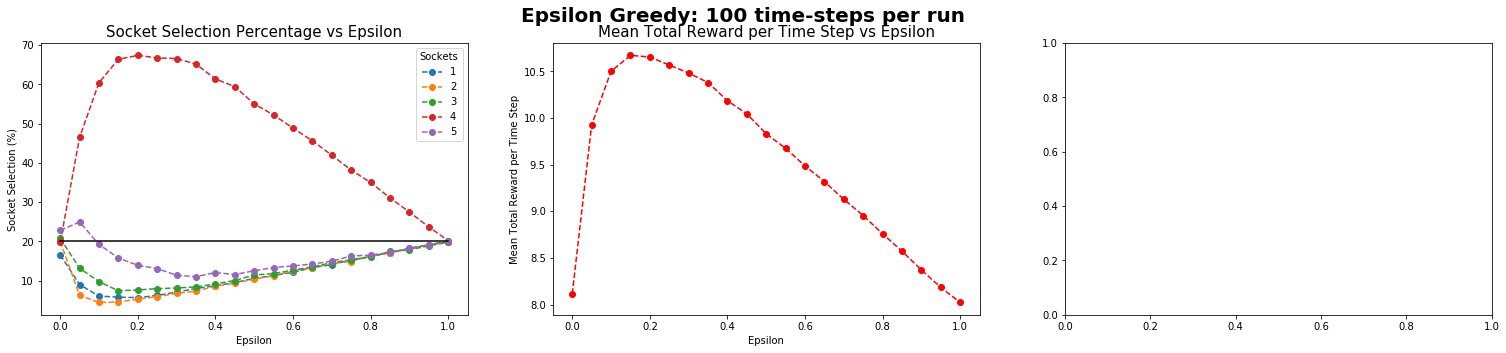

In [9]:
# how many times each test should be run
number_of_tests = 500

# the epsilon test range
start = 0
stop = 1.0
step = 0.05

number_of_steps = 100
epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = 
    run_epsilon_greedy_experiment( start, stop, step, number_of_tests, steps )  

plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps )